# Official implementation
- Below lines are extracted from https://github.com/scipy/scipy/blob/v1.13.0/scipy/interpolate/_bsplines.py

In [1]:
import numpy as np
from scipy.interpolate import BSpline
from scipy.linalg import cholesky_banded, solve_banded, LinAlgError
from scipy.optimize import minimize_scalar


def _coeff_of_divided_diff(x):
    n = x.shape[0]
    res = np.zeros(n)
    for i in range(n):
        pp = 1.0
        for k in range(n):
            if k != i:
                pp *= x[i] - x[k]
        res[i] = 1.0 / pp
    return res


def _compute_optimal_gcv_parameter(X, wE, y, w):
    def compute_banded_symmetric_XT_W_Y(X, w, Y):
        W_Y = np.copy(Y)

        W_Y[2] *= w
        for i in range(2):
            W_Y[i, 2 - i :] *= w[: -2 + i]
            W_Y[3 + i, : -1 - i] *= w[1 + i :]

        n = X.shape[1]
        res = np.zeros((4, n))
        for i in range(n):
            for j in range(min(n - i, 4)):
                res[-j - 1, i + j] = sum(X[j:, i] * W_Y[: 5 - j, i + j])
        return res

    def compute_b_inv(A):
        def find_b_inv_elem(i, j, U, D, B):
            rng = min(3, n - i - 1)
            rng_sum = 0.0
            if j == 0:
                # use 2-nd formula from [1]
                for k in range(1, rng + 1):
                    rng_sum -= U[-k - 1, i + k] * B[-k - 1, i + k]
                rng_sum += D[i]
                B[-1, i] = rng_sum
            else:
                # use 1-st formula from [1]
                for k in range(1, rng + 1):
                    diag = abs(k - j)
                    ind = i + min(k, j)
                    rng_sum -= U[-k - 1, i + k] * B[-diag - 1, ind + diag]
                B[-j - 1, i + j] = rng_sum

        U = cholesky_banded(A)
        for i in range(2, 5):
            U[-i, i - 1 :] /= U[-1, : -i + 1]
        D = 1.0 / (U[-1]) ** 2
        U[-1] /= U[-1]

        n = U.shape[1]

        B = np.zeros(shape=(4, n))
        for i in range(n - 1, -1, -1):
            for j in range(min(3, n - i - 1), -1, -1):
                find_b_inv_elem(i, j, U, D, B)
        # the first row contains garbage and should be removed
        B[0] = [0.0] * n
        return B

    def _gcv(lam, X, XtWX, wE, XtE):
        # Compute the numerator from (2.2.4) [3]
        n = X.shape[1]
        c = solve_banded((2, 2), X + lam * wE, y)
        res = np.zeros(n)
        # compute ``W^{-1} E c`` with respect to banded-storage of ``E``
        tmp = wE * c
        for i in range(n):
            for j in range(max(0, i - n + 3), min(5, i + 3)):
                res[i] += tmp[j, i + 2 - j]
        numer = np.linalg.norm(lam * res) ** 2 / n

        # compute the denominator
        lhs = XtWX + lam * XtE
        try:
            b_banded = compute_b_inv(lhs)
            # compute the trace of the product b_banded @ XtX
            tr = b_banded * XtWX
            tr[:-1] *= 2
            # find the denominator
            denom = (1 - sum(sum(tr)) / n) ** 2
        except LinAlgError:
            # cholesky decomposition cannot be performed
            raise ValueError("Seems like the problem is ill-posed")

        res = numer / denom

        return res

    n = X.shape[1]

    XtWX = compute_banded_symmetric_XT_W_Y(X, w, X)
    XtE = compute_banded_symmetric_XT_W_Y(X, w, wE)

    def fun(lam):
        return _gcv(lam, X, XtWX, wE, XtE)

    gcv_est = minimize_scalar(fun, bounds=(0, n), method="Bounded")
    if gcv_est.success:
        return gcv_est.x
    raise ValueError(f"Unable to find minimum of the GCV " f"function: {gcv_est.message}")


def make_smoothing_spline(x, y, w=None, lam=None):
    x = np.ascontiguousarray(x, dtype=float)
    y = np.ascontiguousarray(y, dtype=float)

    if any(x[1:] - x[:-1] <= 0):
        raise ValueError("``x`` should be an ascending array")

    if x.ndim != 1 or y.ndim != 1 or x.shape[0] != y.shape[0]:
        raise ValueError("``x`` and ``y`` should be one dimensional and the" " same size")

    if w is None:
        w = np.ones(len(x))
    else:
        w = np.ascontiguousarray(w)
        if any(w <= 0):
            raise ValueError("Invalid vector of weights")

    t = np.r_[[x[0]] * 3, x, [x[-1]] * 3]
    n = x.shape[0]

    if n <= 4:
        raise ValueError("``x`` and ``y`` length must be at least 5")

    # It is known that the solution to the stated minimization problem exists
    # and is a natural cubic spline with vector of knots equal to the unique
    # elements of ``x`` [3], so we will solve the problem in the basis of
    # natural splines.

    # create design matrix in the B-spline basis
    X_bspl = BSpline.design_matrix(x, t, 3)
    # move from B-spline basis to the basis of natural splines using equations
    # (2.1.7) [4]
    # central elements
    X = np.zeros((5, n))
    for i in range(1, 4):
        X[i, 2:-2] = X_bspl[i : i - 4, 3:-3][np.diag_indices(n - 4)]

    # first elements
    X[1, 1] = X_bspl[0, 0]
    X[2, :2] = ((x[2] + x[1] - 2 * x[0]) * X_bspl[0, 0], X_bspl[1, 1] + X_bspl[1, 2])
    X[3, :2] = ((x[2] - x[0]) * X_bspl[1, 1], X_bspl[2, 2])

    # last elements
    X[1, -2:] = (X_bspl[-3, -3], (x[-1] - x[-3]) * X_bspl[-2, -2])
    X[2, -2:] = (X_bspl[-2, -3] + X_bspl[-2, -2], (2 * x[-1] - x[-2] - x[-3]) * X_bspl[-1, -1])
    X[3, -2] = X_bspl[-1, -1]

    # create penalty matrix and divide it by vector of weights: W^{-1} E
    wE = np.zeros((5, n))
    wE[2:, 0] = _coeff_of_divided_diff(x[:3]) / w[:3]
    wE[1:, 1] = _coeff_of_divided_diff(x[:4]) / w[:4]
    for j in range(2, n - 2):
        wE[:, j] = (x[j + 2] - x[j - 2]) * _coeff_of_divided_diff(x[j - 2 : j + 3]) / w[j - 2 : j + 3]

    wE[:-1, -2] = -_coeff_of_divided_diff(x[-4:]) / w[-4:]
    wE[:-2, -1] = _coeff_of_divided_diff(x[-3:]) / w[-3:]
    wE *= 6

    if lam is None:
        lam = _compute_optimal_gcv_parameter(X, wE, y, w)
    elif lam < 0.0:
        raise ValueError("Regularization parameter should be non-negative")

    # solve the initial problem in the basis of natural splines
    c = solve_banded((2, 2), X + lam * wE, y)
    # move back to B-spline basis using equations (2.2.10) [4]
    c_ = np.r_[
        c[0] * (t[5] + t[4] - 2 * t[3]) + c[1],
        c[0] * (t[5] - t[3]) + c[1],
        c[1:-1],
        c[-1] * (t[-4] - t[-6]) + c[-2],
        c[-1] * (2 * t[-4] - t[-5] - t[-6]) + c[-2],
    ]

    return BSpline.construct_fast(t, c_, 3)

Elapsed time for smoothed spline: 0.1364 s


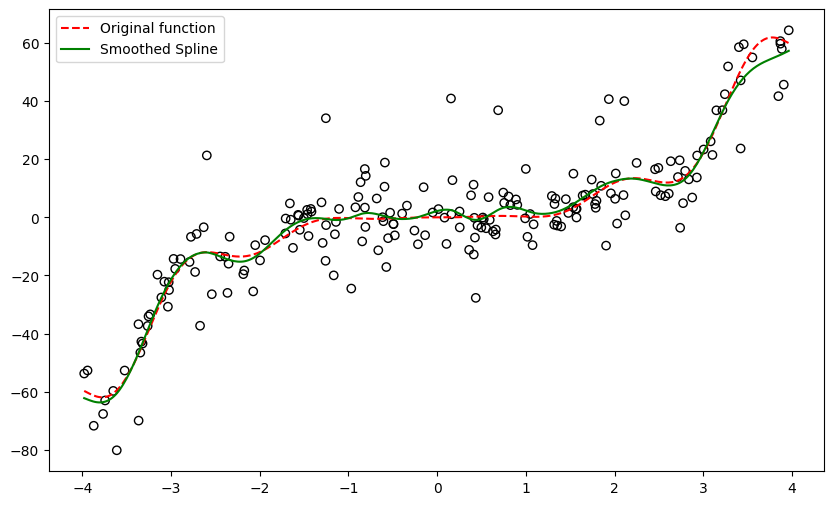

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t, norm
import time

np.random.seed(123)

# Data generation parameters
n = 200
outlier_fraction = 0.3  # 30% of the points are outliers
outlier_scale = 10.0  # Scale of the noise for outliers
inlier_scale = 6.0  # Scale of the noise for inliers


def func(x):
    return x**3 + x**2 * np.sin(4 * x)


# Generate data points
x = np.sort(np.random.random_sample(n) * 8 - 4)
y = func(x)
noise = np.where(
    np.random.rand(n) < outlier_fraction,
    t.rvs(df=3, scale=outlier_scale, size=n),  # Outlier noise
    norm.rvs(scale=inlier_scale, size=n),  # Inlier noise
)
y += noise

# Fit a smoothing spline with a low lambda for a close fit
start = time.perf_counter()
smooth_spl = make_smoothing_spline(x, y)
end = time.perf_counter()
print(f"Elapsed time for smoothed spline: {end - start:.4f} s")

# Plotting
grid = np.linspace(x[0], x[-1], 400)
plt.figure(figsize=(10, 6))
plt.plot(grid, func(grid), "--", label="Original function", color="red")
plt.plot(grid, smooth_spl(grid), label="Smoothed Spline", color="green")
plt.scatter(x, y, marker="o", facecolor="None", edgecolors="black")
plt.legend(loc="best")
plt.show()

# With Numba

In [3]:
import numba as nb
import numpy as np
from numba import njit
from scipy.interpolate import BSpline
from scipy.linalg import cholesky_banded, solve_banded, LinAlgError
from scipy.optimize import minimize_scalar


@njit(cache=True)
def _coeff_of_divided_diff(x):
    n = x.shape[0]
    res = np.zeros(n)
    for i in range(n):
        pp = 1.0
        for k in range(n):
            if k != i:
                pp *= x[i] - x[k]
        res[i] = 1.0 / pp
    return res


@njit(cache=True)
def compute_banded_symmetric_XT_W_Y(X, w, Y):
    W_Y = np.copy(Y)
    W_Y[2] *= w
    for i in range(2):
        W_Y[i, 2 - i :] *= w[: -2 + i]
        W_Y[3 + i, : -1 - i] *= w[1 + i :]

    n = X.shape[1]
    res = np.zeros((4, n))
    for i in range(n):
        for j in range(min(n - i, 4)):
            total = 0.0
            for k in range(len(X[j:, i])):
                total += X[j + k, i] * W_Y[k, i + j]
            res[-j - 1, i + j] = total
    return res


@njit(cache=True)
def find_b_inv_elem(i, j, U, D, B, n):
    rng = min(3, n - i - 1)
    rng_sum = 0.0
    if j == 0:
        # use 2-nd formula from [1]
        for k in range(1, rng + 1):
            rng_sum -= U[-k - 1, i + k] * B[-k - 1, i + k]
        rng_sum += D[i]
        B[-1, i] = rng_sum
    else:
        # use 1-st formula from [1]
        for k in range(1, rng + 1):
            diag = abs(k - j)
            ind = i + min(k, j)
            rng_sum -= U[-k - 1, i + k] * B[-diag - 1, ind + diag]
        B[-j - 1, i + j] = rng_sum


@njit(cache=True)
def compute_b_inv(U):
    # def compute_b_inv(A):
    # U = cholesky_banded(A)
    for i in range(2, 5):
        U[-i, i - 1 :] /= U[-1, : -i + 1]
    D = 1.0 / (U[-1]) ** 2
    U[-1] /= U[-1]
    n = U.shape[1]
    B = np.zeros(shape=(4, n))
    for i in range(n - 1, -1, -1):
        for j in range(min(3, n - i - 1), -1, -1):
            find_b_inv_elem(i, j, U, D, B, n)
    B[0] = [0.0] * n
    return B


@njit(cache=True)
def calculate_res(wE, c, n):
    res = np.zeros(n)
    for i in range(n):
        for j in range(max(0, i - n + 3), min(5, i + 3)):
            res[i] += wE[j, i + 2 - j] * c[i + 2 - j]
    return res


@njit(cache=True)
def calculate_trace(B, XtWX, n):
    tr = 0.0
    for i in range(n):
        tr += B[i] * XtWX[i]
    return tr


def _gcv(lam, X, XtWX, wE, XtE, y):
    n = X.shape[1]
    c = solve_banded((2, 2), X + lam * wE, y)

    res = calculate_res(wE, c, n)
    numer = np.linalg.norm(lam * res) ** 2 / n
    lhs = XtWX + lam * XtE
    try:
        lhs_chor = cholesky_banded(lhs)
        b_banded = compute_b_inv(lhs_chor)
        tr = b_banded * XtWX
        tr[:-1] *= 2
        denom = (1 - sum(sum(tr)) / n) ** 2
    except LinAlgError:
        # If cholesky decomposition fails
        raise ValueError("Problem is ill-posed")
    return numer / denom


def _compute_optimal_gcv_parameter(X, wE, y, w):
    n = X.shape[1]
    XtWX = compute_banded_symmetric_XT_W_Y(X, w, X)
    XtE = compute_banded_symmetric_XT_W_Y(X, w, wE)

    def fun(lam):
        return _gcv(lam, X, XtWX, wE, XtE, y)

    gcv_est = minimize_scalar(fun, bounds=(0, n), method="Bounded")
    if gcv_est.success:
        return gcv_est.x
    raise ValueError(f"Unable to find minimum of the GCV " f"function: {gcv_est.message}")


@njit(cache=True)
def diagonal_numba(matrix, offset=0):
    nrows, ncols = matrix.shape
    diag = []
    start = max(-offset, 0)  # start of the diagonal
    length = min(nrows, ncols - offset)  # end of the diagonal
    for i in range(start, length):
        diag.append(matrix[i, i + offset])
    return np.array(diag)


@njit(cache=True)
def _compute_natural_spline_basis(X_bspl, x, n):
    X = np.zeros((5, n))
    for i in range(1, 4):
        X_bspl_tmp = diagonal_numba(X_bspl[i : i - 4, 3:-3])
        X[i, 2:-2] = X_bspl_tmp

    X[1, 1] = X_bspl[0, 0]
    X[2, :2] = ((x[2] + x[1] - 2 * x[0]) * X_bspl[0, 0], X_bspl[1, 1] + X_bspl[1, 2])
    X[3, :2] = ((x[2] - x[0]) * X_bspl[1, 1], X_bspl[2, 2])

    X[1, -2:] = (X_bspl[-3, -3], (x[-1] - x[-3]) * X_bspl[-2, -2])
    X[2, -2:] = (X_bspl[-2, -3] + X_bspl[-2, -2], (2 * x[-1] - x[-2] - x[-3]) * X_bspl[-1, -1])
    X[3, -2] = X_bspl[-1, -1]
    return X


@njit(cache=True)
def _compute_penalty_matrix(x, w, n):
    wE = np.zeros((5, n))
    wE[2:, 0] = _coeff_of_divided_diff(x[:3]) / w[:3]
    wE[1:, 1] = _coeff_of_divided_diff(x[:4]) / w[:4]
    for j in range(2, n - 2):
        wE[:, j] = (x[j + 2] - x[j - 2]) * _coeff_of_divided_diff(x[j - 2 : j + 3]) / w[j - 2 : j + 3]
    wE[:-1, -2] = -_coeff_of_divided_diff(x[-4:]) / w[-4:]
    wE[:-2, -1] = _coeff_of_divided_diff(x[-3:]) / w[-3:]
    wE *= 6
    return wE


def make_smoothing_spline(x, y, w=None, lam=None):
    x = np.ascontiguousarray(x, dtype=float)
    y = np.ascontiguousarray(y, dtype=float)

    if any(x[1:] - x[:-1] <= 0):
        raise ValueError("``x`` should be an ascending array")

    if x.ndim != 1 or y.ndim != 1 or x.shape[0] != y.shape[0]:
        raise ValueError("``x`` and ``y`` should be one dimensional and the" " same size")

    if w is None:
        w = np.ones(len(x))
    else:
        w = np.ascontiguousarray(w)
        if any(w <= 0):
            raise ValueError("Invalid vector of weights")

    t = np.r_[[x[0]] * 3, x, [x[-1]] * 3]
    n = x.shape[0]

    if n <= 4:
        raise ValueError("``x`` and ``y`` length must be at least 5")

    # It is known that the solution to the stated minimization problem exists
    # and is a natural cubic spline with vector of knots equal to the unique
    # elements of ``x`` [3], so we will solve the problem in the basis of
    # natural splines.
    # create design matrix in the B-spline basis
    X_bspl = BSpline.design_matrix(x, t, 3)

    # move from B-spline basis to the basis of natural splines using equations
    # (2.1.7) [4]
    # central elements
    X = _compute_natural_spline_basis(X_bspl.toarray(), x, n)

    # create penalty matrix and divide it by vector of weights: W^{-1} E
    wE = _compute_penalty_matrix(x, w, n)

    if lam is None:
        lam = _compute_optimal_gcv_parameter(X, wE, y, w)
    elif lam < 0.0:
        raise ValueError("Regularization parameter should be non-negative")

    # solve the initial problem in the basis of natural splines
    c = solve_banded((2, 2), X + lam * wE, y)

    # move back to B-spline basis using equations (2.2.10) [4]
    c_ = np.r_[
        c[0] * (t[5] + t[4] - 2 * t[3]) + c[1],
        c[0] * (t[5] - t[3]) + c[1],
        c[1:-1],
        c[-1] * (t[-4] - t[-6]) + c[-2],
        c[-1] * (2 * t[-4] - t[-5] - t[-6]) + c[-2],
    ]
    return BSpline.construct_fast(t, c_, 3)

Elapsed time for smoothed spline: 0.005 s


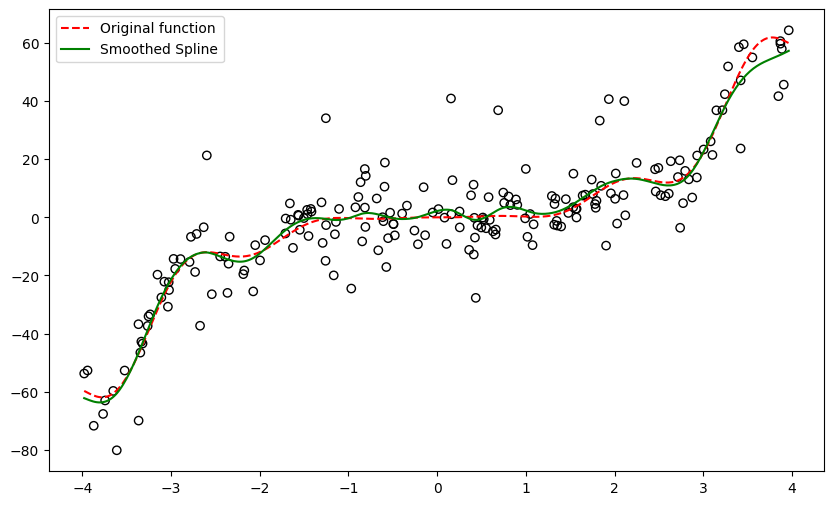

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t, norm
import time

np.random.seed(123)

# Data generation parameters
n = 200
outlier_fraction = 0.3  # 30% of the points are outliers
outlier_scale = 10.0  # Scale of the noise for outliers
inlier_scale = 6.0  # Scale of the noise for inliers


def func(x):
    return x**3 + x**2 * np.sin(4 * x)


# Generate data points
x = np.sort(np.random.random_sample(n) * 8 - 4)
y = func(x)
noise = np.where(
    np.random.rand(n) < outlier_fraction,
    t.rvs(df=3, scale=outlier_scale, size=n),  # Outlier noise
    norm.rvs(scale=inlier_scale, size=n),  # Inlier noise
)
y += noise

# Airshoot for numba compilation
make_smoothing_spline(x, y)

# Fit a smoothing spline with a low lambda for a close fit
start = time.perf_counter()
smooth_spl = make_smoothing_spline(x, y)
end = time.perf_counter()
print(f"Elapsed time for smoothed spline: {end - start:.3f} s")

# Plotting
grid = np.linspace(x[0], x[-1], 400)
plt.figure(figsize=(10, 6))
plt.plot(grid, func(grid), "--", label="Original function", color="red")
plt.plot(grid, smooth_spl(grid), label="Smoothed Spline", color="green")
plt.scatter(x, y, marker="o", facecolor="None", edgecolors="black")
plt.legend(loc="best")
plt.show()